# Phase 2: Data Cleaning & Preprocessing

**Objective**: Clean and preprocess the HMDA dataset for modeling

**Tasks**:
- Task 2.1: Data Quality Assessment
- Task 2.2: Handle Missing Values
- Task 2.3: Filter and Subset Data
- Task 2.4: Encode Categorical Variables

**Expected Output**: `data/processed/cleaned_data.csv`

## Setup

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import json
from datetime import datetime

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
%matplotlib inline

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
# Set up paths
BASE_DIR = Path('/Users/josiahgordor/Desktop/DSPortfolio/Projects/loan_approval')
DATA_RAW = BASE_DIR / 'data' / 'raw'
DATA_PROCESSED = BASE_DIR / 'data' / 'processed'
REPORTS = BASE_DIR / 'reports'
SRC = BASE_DIR / 'src' / 'data'

# Create directories if they don't exist
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)
REPORTS.mkdir(parents=True, exist_ok=True)
SRC.mkdir(parents=True, exist_ok=True)

print(f"✅ Directory structure verified")
print(f"Data raw: {DATA_RAW}")
print(f"Data processed: {DATA_PROCESSED}")


✅ Directory structure verified
Data raw: /Users/josiahgordor/Desktop/DSPortfolio/Projects/loan_approval/data/raw
Data processed: /Users/josiahgordor/Desktop/DSPortfolio/Projects/loan_approval/data/processed


## Load Data

In [3]:
# Load the processed HMDA dataset with target variable
# This file was created in Task 1.3 (02_target_definition.ipynb)
data_path = DATA_PROCESSED / 'hmda_with_target.csv'

print(f"Loading data from: {data_path}")
print("⏳ This may take 2-3 minutes for the full dataset...\n")

# Load full dataset with target variable
df = pd.read_csv(data_path, low_memory=False)

# Standardize column names
df.columns = df.columns.str.lower().str.replace(' ', '_')

print(f"✅ Data loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1e9:.2f} GB")

# Save initial row count
initial_rows = len(df)
print(f"\nInitial dataset: {initial_rows:,} rows")

# Verify target variable exists
if 'target' in df.columns:
    print(f"Target variable present: {df['target'].notna().sum():,} valid values")
    print(f"Approval rate: {df['target'].mean()*100:.1f}%")
else:
    print("⚠️  Warning: Target variable not found in dataset!")


Loading data from: /Users/josiahgordor/Desktop/DSPortfolio/Projects/loan_approval/data/processed/hmda_with_target.csv
⏳ This may take 2-3 minutes for the full dataset...

✅ Data loaded successfully!
Shape: (1603865, 102)
Memory Usage: 7.92 GB

Initial dataset: 1,603,865 rows
Target variable present: 1,603,865 valid values
Approval rate: 76.3%


---
# Task 2.1: Data Quality Assessment

## 2.1.1: Missing Values Analysis

In [4]:
# Calculate missing value statistics
missing_count = df.isnull().sum()
missing_pct = (missing_count / len(df) * 100)

# Create dataframe with aligned indices
missing_df = pd.DataFrame({
    'Column': missing_count.index,
    'Missing_Count': missing_count.values,
    'Missing_Percentage': missing_pct.values
})

# Sort by missing percentage (descending)
missing_df = missing_df.sort_values('Missing_Percentage', ascending=False)

# Columns with missing values
columns_with_missing = missing_df[missing_df['Missing_Percentage'] > 0]
columns_to_drop_missing = missing_df[missing_df['Missing_Percentage'] > 40]

print("="*80)
print("MISSING VALUES ANALYSIS")
print("="*80)
print(f"\nColumns with missing values: {len(columns_with_missing)} out of {len(df.columns)}")
print(f"\nTop 20 columns with highest missing percentages:\n")
print(columns_with_missing.head(20).to_string(index=False))


MISSING VALUES ANALYSIS

Columns with missing values: 33 out of 102

Top 20 columns with highest missing percentages:

                      Column  Missing_Count  Missing_Percentage
    co_applicant_ethnicity_5        1603855           99.999377
    co_applicant_ethnicity_4        1603845           99.998753
       applicant_ethnicity_5        1603844           99.998691
       applicant_ethnicity_4        1603812           99.996695
         co_applicant_race_5        1603743           99.992393
         co_applicant_race_4        1603540           99.979736
            applicant_race_5        1603539           99.979674
    co_applicant_ethnicity_3        1603101           99.952365
            applicant_race_4        1602917           99.940893
             denial_reason_4        1602671           99.925555
       applicant_ethnicity_3        1601549           99.855599
         co_applicant_race_3        1601477           99.851110
            applicant_race_3        1596999      

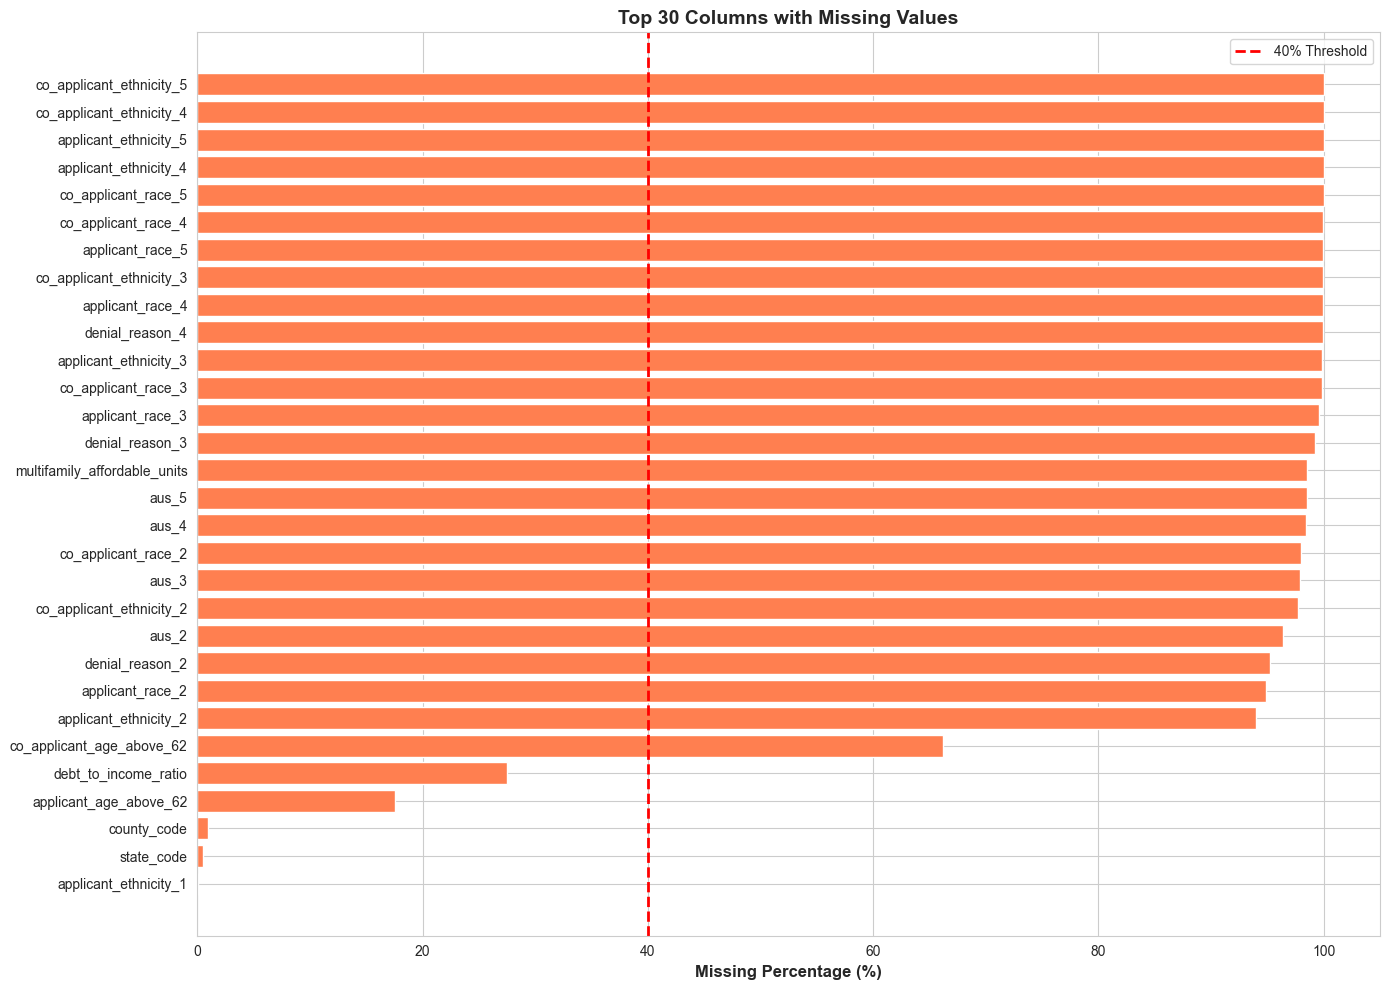

In [5]:
# Visualize missing values for top 30 columns
if len(columns_with_missing) > 0:
    plt.figure(figsize=(14, 10))
    top_missing = columns_with_missing.head(30)
    
    plt.barh(range(len(top_missing)), top_missing['Missing_Percentage'], color='coral')
    plt.yticks(range(len(top_missing)), top_missing['Column'])
    plt.xlabel('Missing Percentage (%)', fontsize=12, fontweight='bold')
    plt.title('Top 30 Columns with Missing Values', fontsize=14, fontweight='bold')
    plt.axvline(x=40, color='red', linestyle='--', linewidth=2, label='40% Threshold')
    plt.legend()
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("✅ No missing values to visualize")

## 2.1.2: Duplicate Records Check

In [6]:
# Check for complete duplicate rows
duplicate_count = df.duplicated().sum()
duplicate_pct = (duplicate_count / len(df)) * 100

print("="*80)
print("DUPLICATE RECORDS ANALYSIS")
print("="*80)
print(f"\nTotal Duplicate Rows: {duplicate_count:,} ({duplicate_pct:.2f}%)")

if duplicate_count > 0:
    print("\n⚠️  Duplicates found - will remove in cleaning step")
else:
    print("\n✅ No duplicate rows found")

DUPLICATE RECORDS ANALYSIS

Total Duplicate Rows: 0 (0.00%)

✅ No duplicate rows found


## 2.1.3: Data Range Validation

In [7]:
# Define key numeric columns to validate
validation_rules = {
    'income': {'min': 0, 'max': 1000000, 'name': 'Income'},
    'loan_amount': {'min': 0, 'max': 100000000, 'name': 'Loan Amount'},
    'property_value': {'min': 0, 'max': 200000000, 'name': 'Property Value'},
    'interest_rate': {'min': 0, 'max': 20, 'name': 'Interest Rate'},
    'loan_term': {'min': 0, 'max': 480, 'name': 'Loan Term (months)'},
}

print("="*80)
print("DATA RANGE VALIDATION")
print("="*80)

validation_issues = []

for col, rules in validation_rules.items():
    if col in df.columns:
        # Convert to numeric if not already
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
        below_min = (df[col] < rules['min']).sum()
        above_max = (df[col] > rules['max']).sum()
        
        print(f"\n{rules['name']} ({col}):")
        print(f"  Valid range: {rules['min']:,} - {rules['max']:,}")
        print(f"  Below minimum: {below_min:,}")
        print(f"  Above maximum: {above_max:,}")
        
        if below_min > 0 or above_max > 0:
            validation_issues.append(col)
            print(f"  ⚠️  Issues found!")
        else:
            print(f"  ✅ All values within range")
    else:
        print(f"\n⚠️  {rules['name']} ({col}): Column not found")

if validation_issues:
    print(f"\n⚠️  {len(validation_issues)} column(s) have validation issues")
else:
    print("\n✅ All columns pass validation checks")

DATA RANGE VALIDATION

Income (income):
  Valid range: 0 - 1,000,000
  Below minimum: 898
  Above maximum: 9
  ⚠️  Issues found!

Loan Amount (loan_amount):
  Valid range: 0 - 100,000,000
  Below minimum: 0
  Above maximum: 36
  ⚠️  Issues found!

Property Value (property_value):
  Valid range: 0 - 200,000,000
  Below minimum: 0
  Above maximum: 71
  ⚠️  Issues found!

Interest Rate (interest_rate):
  Valid range: 0 - 20
  Below minimum: 0
  Above maximum: 0
  ✅ All values within range

Loan Term (months) (loan_term):
  Valid range: 0 - 480
  Below minimum: 0
  Above maximum: 7
  ⚠️  Issues found!

⚠️  4 column(s) have validation issues


## 2.1.4: Data Quality Summary

In [8]:
# Create comprehensive data quality report
quality_report = {
    'total_rows': len(df),
    'total_columns': len(df.columns),
    'columns_with_missing': len(columns_with_missing),
    'duplicate_rows': int(duplicate_count),
    'columns_with_validation_issues': validation_issues,
    'memory_usage_gb': float(df.memory_usage(deep=True).sum() / 1e9)
}

print("="*80)
print("DATA QUALITY SUMMARY")
print("="*80)
print(f"\nTotal Rows: {quality_report['total_rows']:,}")
print(f"Total Columns: {quality_report['total_columns']}")
print(f"Columns with Missing Values: {quality_report['columns_with_missing']}")
print(f"Duplicate Rows: {quality_report['duplicate_rows']:,}")
print(f"Memory Usage: {quality_report['memory_usage_gb']:.2f} GB")

# Save quality report
quality_report_path = REPORTS / 'data_quality_assessment.json'
with open(quality_report_path, 'w') as f:
    json.dump(quality_report, f, indent=2)

print(f"\n✅ Quality report saved to: {quality_report_path}")


DATA QUALITY SUMMARY

Total Rows: 1,603,865
Total Columns: 102
Columns with Missing Values: 33
Duplicate Rows: 0
Memory Usage: 7.92 GB

✅ Quality report saved to: /Users/josiahgordor/Desktop/DSPortfolio/Projects/loan_approval/reports/data_quality_assessment.json


---
# Task 2.2: Handle Missing Values

## 2.2.1: Drop Columns with >40% Missing

In [9]:
# Identify columns with >40% missing for removal
# Exclude debt_to_income_ratio even if it exceeds threshold (important feature)
high_missing = columns_with_missing[columns_with_missing['Missing_Percentage'] > 40]
cols_to_drop_missing = high_missing['Column'].tolist()

# Exclude debt_to_income_ratio from removal
if 'debt_to_income_ratio' in cols_to_drop_missing:
    cols_to_drop_missing.remove('debt_to_income_ratio')
    print(f"ℹ️  Keeping 'debt_to_income_ratio' despite high missing percentage (important feature)\n")

print(f"Columns to drop (>40% missing): {len(cols_to_drop_missing)}")
if cols_to_drop_missing:
    print("\nSample columns to be dropped:")
    for col in cols_to_drop_missing[:10]:
        pct = missing_df[missing_df['Column'] == col]['Missing_Percentage'].values[0]
        print(f"  - {col}: {pct:.1f}% missing")
    if len(cols_to_drop_missing) > 10:
        print(f"  ... and {len(cols_to_drop_missing) - 10} more columns")


Columns to drop (>40% missing): 25

Sample columns to be dropped:
  - co_applicant_ethnicity_5: 100.0% missing
  - co_applicant_ethnicity_4: 100.0% missing
  - applicant_ethnicity_5: 100.0% missing
  - applicant_ethnicity_4: 100.0% missing
  - co_applicant_race_5: 100.0% missing
  - co_applicant_race_4: 100.0% missing
  - applicant_race_5: 100.0% missing
  - co_applicant_ethnicity_3: 100.0% missing
  - applicant_race_4: 99.9% missing
  - denial_reason_4: 99.9% missing
  ... and 15 more columns


In [10]:
print("="*80)
print("DROPPING COLUMNS WITH >40% MISSING VALUES")
print("="*80)

if cols_to_drop_missing:
    print(f"\nDropping {len(cols_to_drop_missing)} columns:")
    for col in cols_to_drop_missing[:10]:  # Show first 10
        pct = missing_df[missing_df['Column'] == col]['Missing_Percentage'].values[0]
        print(f"  - {col}: {pct:.1f}% missing")
    if len(cols_to_drop_missing) > 10:
        print(f"  ... and {len(cols_to_drop_missing) - 10} more")
    
    df = df.drop(columns=cols_to_drop_missing)
    print(f"\n✅ Dropped {len(cols_to_drop_missing)} columns")
    print(f"New shape: {df.shape}")
else:
    print("\n✅ No columns to drop")

columns_dropped_missing = cols_to_drop_missing.copy() if cols_to_drop_missing else []


DROPPING COLUMNS WITH >40% MISSING VALUES

Dropping 25 columns:
  - co_applicant_ethnicity_5: 100.0% missing
  - co_applicant_ethnicity_4: 100.0% missing
  - applicant_ethnicity_5: 100.0% missing
  - applicant_ethnicity_4: 100.0% missing
  - co_applicant_race_5: 100.0% missing
  - co_applicant_race_4: 100.0% missing
  - applicant_race_5: 100.0% missing
  - co_applicant_ethnicity_3: 100.0% missing
  - applicant_race_4: 99.9% missing
  - denial_reason_4: 99.9% missing
  ... and 15 more

✅ Dropped 25 columns
New shape: (1603865, 77)


In [11]:
df.county_code = df.county_code.astype(str).str.zfill(5)
df.state_code = df.state_code.astype(str).str.zfill(3)

## 2.2.2: Impute Missing Values

In [12]:
print("="*80)
print("MISSING VALUE IMPUTATION STRATEGY")
print("="*80)

# Define imputation strategy
imputation_strategy = {}

# Numeric columns: median imputation
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols_with_missing = []
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        numeric_cols_with_missing.append(col)

print(f"\nNumeric columns with missing values: {len(numeric_cols_with_missing)}")
print("Strategy: Median imputation\n")

for col in numeric_cols_with_missing:
    missing_count = df[col].isnull().sum()
    missing_pct = (missing_count / len(df)) * 100
    
    if missing_pct > 0 and missing_pct <= 40:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        imputation_strategy[col] = {'method': 'median', 'value': float(median_val)}
        print(f"  ✅ {col}: Imputed {missing_count:,} values with median ({median_val:.2f})")

# # Categorical columns: mode or 'Unknown'
# categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
# categorical_cols_with_missing = []
# for col in categorical_cols:
#     if df[col].isnull().sum() > 0:
#         categorical_cols_with_missing.append(col)

# print(f"\n\nCategorical columns with missing values: {len(categorical_cols_with_missing)}")
# print("Strategy: 'Unknown' category or mode imputation\n")

# for col in categorical_cols_with_missing:
#     missing_count = df[col].isnull().sum()
#     missing_pct = (missing_count / len(df)) * 100
    
#     if missing_pct > 0 and missing_pct <= 40:
#         # Use 'Unknown' for most categorical columns
#         df[col] = df[col].fillna('Unknown')
#         imputation_strategy[col] = {'method': 'constant', 'value': 'Unknown'}
#         print(f"  ✅ {col}: Imputed {missing_count:,} values with 'Unknown'")

# print(f"\n✅ Imputation complete for {len(imputation_strategy)} columns")


MISSING VALUE IMPUTATION STRATEGY

Numeric columns with missing values: 0
Strategy: Median imputation



## 2.2.3: Drop Rows with Critical Missing Values

In [13]:
# Define critical columns that cannot be missing
# Note: 'target' is already created and loaded from processed data (Task 1.3)
# Only drop rows missing absolutely essential fields for modeling
critical_columns = ['income', 'loan_amount', 'property_value', 'target']

print("="*80)
print("DROPPING ROWS WITH CRITICAL MISSING VALUES")
print("="*80)

# Check which critical columns exist
critical_cols_present = [col for col in critical_columns if col in df.columns]

print(f"\nCritical columns: {critical_cols_present}")
print("Strategy: Drop rows if any critical column is missing")
print("Note: Target variable already exists from Task 1.3\n")

rows_before = len(df)

for col in critical_cols_present:
    missing_count = df[col].isnull().sum()
    if missing_count > 0:
        print(f"  {col}: {missing_count:,} missing values")

# Drop rows where any critical column is missing
df = df.dropna(subset=critical_cols_present)

rows_after = len(df)
rows_dropped = rows_before - rows_after

print(f"\n✅ Dropped {rows_dropped:,} rows with critical missing values")
print(f"Remaining rows: {rows_after:,}")
print(f"Percentage retained: {(rows_after/rows_before)*100:.1f}%")


DROPPING ROWS WITH CRITICAL MISSING VALUES

Critical columns: ['income', 'loan_amount', 'property_value', 'target']
Strategy: Drop rows if any critical column is missing
Note: Target variable already exists from Task 1.3


✅ Dropped 0 rows with critical missing values
Remaining rows: 1,603,865
Percentage retained: 100.0%


---
# Task 2.3: Filter and Subset Data

## 2.3.1: Verify Target Variable (Already Created in Task 1.3)

In [14]:
print("="*80)
print("VERIFY TARGET VARIABLE")
print("="*80)

if 'target' in df.columns:
    print("\n✅ Target variable already exists (loaded from processed data)")
    
    # Show distribution
    print("\nTarget Distribution:")
    target_counts = df['target'].value_counts(normalize=True, dropna=False)
    print(target_counts)
    
    print("\nTarget Encoding:")
    print("  Approved (1): Loan originated, Application approved but not accepted, Purchased loan")
    print("  Denied (0): Application denied")
    print("  Excluded (NaN): Withdrawn, Incomplete, Preapproval requests")
    
    print("\n✅ Target variable verified")
else:
    print("\n⚠️  ERROR: 'target' column not found!")
    print("Please run Task 1.3 (02_target_definition.ipynb) first to create the target variable.")


VERIFY TARGET VARIABLE

✅ Target variable already exists (loaded from processed data)

Target Distribution:
1.0    0.76309
0.0    0.23691
Name: target, dtype: float64

Target Encoding:
  Approved (1): Loan originated, Application approved but not accepted, Purchased loan
  Denied (0): Application denied
  Excluded (NaN): Withdrawn, Incomplete, Preapproval requests

✅ Target variable verified


## 2.3.2: Filter for Relevant Applications

In [15]:
print("="*80)
print("FILTERING FOR RELEVANT APPLICATIONS")
print("="*80)

rows_before_filter = len(df)

# Filter 1: Remove rows with NaN target (withdrawn, incomplete, preapprovals)
print("\nFilter 1: Exclude withdrawn/incomplete applications")
df = df[df['target'].notna()]
print(f"  Removed {rows_before_filter - len(df):,} rows")
print(f"  Remaining: {len(df):,} rows")

rows_after_target = len(df)

# # Filter 2: Owner-occupied principal residences only
if 'occupancy_type' in df.columns:
    print("\nFilter 2: Owner-occupied principal residences only (occupancy_type == 'Principal residence')")
    df = df[df['occupancy_type'] == 'Principal residence']
    print(f"  Removed {rows_after_target - len(df):,} rows")
    print(f"  Remaining: {len(df):,} rows")
    rows_after_occupancy = len(df)
else:
    print("\n⚠️  'occupancy_type' column not found - skipping filter")
    rows_after_occupancy = len(df)

# Filter 3: Home purchase loans only (exclude refinance)
if 'loan_purpose' in df.columns:
    print("\nFilter 3: Home purchase loans only (loan_purpose == 'Home purchase')")
    df = df[df['loan_purpose'] == 'Home purchase']
    print(f"  Removed {rows_after_occupancy - len(df):,} rows")
    print(f"  Remaining: {len(df):,} rows")
    rows_after_purpose = len(df)
else:
    print("\n⚠️  'loan_purpose' column not found - skipping filter")
    rows_after_purpose = len(df)

print(f"\n✅ Filtering complete")
print(f"Total rows removed: {rows_before_filter - len(df):,}")
print(f"Percentage retained: {(len(df)/rows_before_filter)*100:.1f}%")

FILTERING FOR RELEVANT APPLICATIONS

Filter 1: Exclude withdrawn/incomplete applications
  Removed 0 rows
  Remaining: 1,603,865 rows

Filter 2: Owner-occupied principal residences only (occupancy_type == 'Principal residence')
  Removed 148,987 rows
  Remaining: 1,454,878 rows

Filter 3: Home purchase loans only (loan_purpose == 'Home purchase')
  Removed 736,808 rows
  Remaining: 718,070 rows

✅ Filtering complete
Total rows removed: 885,795
Percentage retained: 44.8%


## 2.3.3: Remove Outliers

In [16]:
print("="*80)
print("OUTLIER REMOVAL")
print("="*80)

rows_before_outliers = len(df)

# Define outlier thresholds
outlier_thresholds = {
    'loan_amount': {'max': 3000000, 'name': 'Loan Amount'},
    'income': {'max': 500000, 'name': 'Income'},
    'property_value': {'max': 5000000, 'name': 'Property Value'}
}

outliers_removed = {}

for col, rules in outlier_thresholds.items():
    if col in df.columns:
        before = len(df)
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Remove extreme outliers (keep reasonable values)
        # Keep values > 0 and <= max threshold
        df = df[(df[col] > 0) & (df[col] <= rules['max'])]
        
        removed = before - len(df)
        outliers_removed[col] = removed
        
        print(f"\n{rules['name']} ({col}):")
        print(f"  Threshold: ≤ ${rules['max']:,}")
        print(f"  Removed: {removed:,} rows")
        print(f"  Remaining: {len(df):,} rows")
    else:
        print(f"\n⚠️  {rules['name']} ({col}): Column not found")

total_outliers_removed = rows_before_outliers - len(df)
print(f"\n✅ Outlier removal complete")
print(f"Total outliers removed: {total_outliers_removed:,}")
print(f"Percentage retained: {(len(df)/rows_before_outliers)*100:.1f}%")

OUTLIER REMOVAL

Loan Amount (loan_amount):
  Threshold: ≤ $3,000,000
  Removed: 667 rows
  Remaining: 717,403 rows

Income (income):
  Threshold: ≤ $500,000
  Removed: 204,941 rows
  Remaining: 512,462 rows

Property Value (property_value):
  Threshold: ≤ $5,000,000
  Removed: 18,894 rows
  Remaining: 493,568 rows

✅ Outlier removal complete
Total outliers removed: 224,502
Percentage retained: 68.7%


## 2.3.4: Remove Duplicates

In [17]:
print("="*80)
print("DUPLICATE REMOVAL")
print("="*80)

rows_before_dedup = len(df)
df = df.drop_duplicates()
rows_after_dedup = len(df)
duplicates_removed = rows_before_dedup - rows_after_dedup

print(f"\nDuplicates removed: {duplicates_removed:,}")
print(f"Remaining rows: {rows_after_dedup:,}")

if duplicates_removed > 0:
    print("\n✅ Duplicates removed")
else:
    print("\n✅ No duplicates found")

DUPLICATE REMOVAL

Duplicates removed: 0
Remaining rows: 493,568

✅ No duplicates found


### DROP UNNECESSARY COLS

---
# Task 2.4: Encode Categorical Variables

## 2.4.1: Identify Categorical Columns

In [22]:
print("="*80)
print("CATEGORICAL VARIABLE IDENTIFICATION")
print("="*80)

# Identify categorical columns (object dtype) and exclude action_taken
categorical_cols_index = df.select_dtypes(include=["object"]).columns
categorical_cols = categorical_cols_index.difference(["action_taken"], sort=False).tolist()

print(f"\nFound {len(categorical_cols)} categorical columns")

if not categorical_cols:
    print("\n⚠️  No categorical columns remaining after filtering")
    print("All categorical columns may have been dropped or encoded earlier")
    cardinality_df = pd.DataFrame(columns=["column", "n_unique", "cardinality"])
    low_cardinality = []
    medium_cardinality = []
    high_cardinality = []
else:
    cardinality_series = df[categorical_cols].nunique(dropna=False)
    cardinality_df = (
        cardinality_series
        .sort_values(ascending=False)
        .reset_index()
        .rename(columns={"index": "column", 0: "n_unique"})
    )
    
    def categorize_cardinality(n_unique: int) -> str:
        if n_unique > 50:
            return "high"
        if n_unique > 10:
            return "medium"
        return "low"
    
    cardinality_df["cardinality"] = cardinality_df["n_unique"].apply(categorize_cardinality)
    
    print("\nTop 20 by cardinality:")
    print(cardinality_df.head(20).to_string(index=False))
    
    low_cardinality = cardinality_df[cardinality_df["cardinality"] == "low"]["column"].tolist()
    medium_cardinality = cardinality_df[cardinality_df["cardinality"] == "medium"]["column"].tolist()
    high_cardinality = cardinality_df[cardinality_df["cardinality"] == "high"]["column"].tolist()
    
    print(f"\n📊 Cardinality Summary:")
    print(f"  Low (≤10 unique): {len(low_cardinality)} columns")
    print(f"  Medium (11-50): {len(medium_cardinality)} columns")
    print(f"  High (>50): {len(high_cardinality)} columns")

CATEGORICAL VARIABLE IDENTIFICATION

Found 47 categorical columns

Top 20 by cardinality:
                                  column  n_unique cardinality
                             county_code      3078        high
                                     lei       356        high
                              state_code        54        high
                     co_applicant_race_1        20      medium
                    debt_to_income_ratio        20      medium
                        applicant_race_1        19      medium
          co_applicant_credit_score_type        14      medium
             applicant_credit_score_type        13      medium
                          purchaser_type        11      medium
                co_applicant_ethnicity_1        10         low
                         denial_reason_1        10         low
                            derived_race         9         low
                        co_applicant_age         9         low
                   applicant

## 2.4.2: One-Hot Encoding (Low Cardinality)

In [28]:
print("="*80)
print("ONE-HOT ENCODING (Low Cardinality Columns)")
print("="*80)

# Define columns to one-hot encode
cols_to_onehot = []

# Common HMDA categorical columns
potential_onehot_cols = [
    'property_type',
    'loan_type', 
    'construction_method',
    'occupancy_type',
    'loan_purpose',
]

for col in potential_onehot_cols:
    if col in df.columns and col in low_cardinality:
        cols_to_onehot.append(col)

# Check for duplicate column names
print("\n🔍 Diagnostic: Checking for duplicate columns...")
duplicate_cols = df.columns[df.columns.duplicated()].tolist()
if duplicate_cols:
    print(f"⚠️  WARNING: Found {len(duplicate_cols)} duplicate column(s):")
    for dup in duplicate_cols:
        print(f"  - '{dup}' appears {list(df.columns).count(dup)} times")
    print("\nRemoving duplicate columns...")
    df = df.loc[:, ~df.columns.duplicated()]
    print(f"✅ Duplicates removed. New shape: {df.shape}")
else:
    print("✅ No duplicate columns found")

print(f"\nColumns to one-hot encode: {len(cols_to_onehot)}")
for col in cols_to_onehot:
    n_unique = df[col].nunique()
    print(f"  - {col}: {n_unique} unique values")

if cols_to_onehot:
    # Perform one-hot encoding
    # Create prefix dict to match each column to its name
    prefix_dict = {col: col for col in cols_to_onehot}
    df_encoded = pd.get_dummies(df, columns=cols_to_onehot, prefix=prefix_dict, drop_first=True)
    
    new_cols = len(df_encoded.columns) - len(df.columns)
    print(f"\n✅ One-hot encoding complete")
    print(f"Added {new_cols} new columns")
    print(f"New shape: {df_encoded.shape}")
    
    df = df_encoded
else:
    print("\n⚠️  No columns identified for one-hot encoding")

ONE-HOT ENCODING (Low Cardinality Columns)

🔍 Diagnostic: Checking for duplicate columns...
⚠️  WARNING: Found 3 duplicate column(s):
  - 'lien_status' appears 2 times
  - 'construction_method' appears 2 times
  - 'total_units' appears 2 times

Removing duplicate columns...
✅ Duplicates removed. New shape: (493568, 74)

Columns to one-hot encode: 4
  - loan_type: 4 unique values
  - construction_method: 2 unique values
  - occupancy_type: 1 unique values
  - loan_purpose: 1 unique values

✅ One-hot encoding complete
Added 0 new columns
New shape: (493568, 74)


## 2.4.3: Label Encoding (High Cardinality - Will Use for Target Encoding in Feature Engineering)

In [ ]:
print("="*80)
print("HIGH CARDINALITY COLUMNS (For Future Target Encoding)")
print("="*80)

# Identify high-cardinality columns for target encoding in Phase 3
high_cardinality_geographic = []

potential_target_encode_cols = [
    'county_code',
    'state_code',
]

for col in potential_target_encode_cols:
    if col in df.columns and col in high_cardinality:
        high_cardinality_geographic.append(col)

print(f"\nHigh-cardinality geographic columns: {len(high_cardinality_geographic)}")
for col in high_cardinality_geographic:
    n_unique = df[col].nunique()
    print(f"  - {col}: {n_unique:,} unique values")

print("\n📝 Note: These will be target-encoded in Phase 3 (Feature Engineering)")
print("   For now, keeping as-is to preserve information for target encoding")

HIGH CARDINALITY COLUMNS (For Future Target Encoding)

High-cardinality geographic columns: 2
  - county_code: 3,078 unique values
  - state_code: 54 unique values

📝 Note: These will be target-encoded in Phase 3 (Feature Engineering)
   For now, keeping as-is to preserve information for target encoding


## 2.4.4: Save Encoding Mappings

In [30]:
# Save encoding strategy for documentation
encoding_strategy = {
    'one_hot_encoded': cols_to_onehot,
    'high_cardinality_for_target_encoding': high_cardinality_geographic,
    'target_variable': {
        'column': 'target',
        'encoding': {
            'approved': 1,
            'denied': 0
        }
    },
    'date_created': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

encoding_path = SRC / 'encodings.json'
with open(encoding_path, 'w') as f:
    json.dump(encoding_strategy, f, indent=2)

print("="*80)
print("ENCODING STRATEGY SAVED")
print("="*80)
print(f"\n✅ Encoding mappings saved to: {encoding_path}")

ENCODING STRATEGY SAVED

✅ Encoding mappings saved to: /Users/josiahgordor/Desktop/DSPortfolio/Projects/loan_approval/src/data/encodings.json


In [31]:
print("="*80)
print("PHASE 2 COMPLETE - DATA CLEANING SUMMARY")
print("="*80)

final_rows = len(df)
retention_rate = (final_rows / initial_rows) * 100

print(f"\n📊 Data Transformation Summary:")
print(f"  Initial rows: {initial_rows:,}")
print(f"  Final rows: {final_rows:,}")
print(f"  Rows removed: {initial_rows - final_rows:,}")
print(f"  Retention rate: {retention_rate:.1f}%")

print(f"\n  Initial columns: {len(df.columns)}")
print(f"  Final columns: {len(df.columns)}")

print(f"\n🎯 Target Variable:")
if 'target' in df.columns:
    target_dist = df['target'].value_counts()
    print(f"  Approved (1): {target_dist.get(1, 0):,} ({target_dist.get(1, 0)/len(df)*100:.1f}%)")
    print(f"  Denied (0): {target_dist.get(0, 0):,} ({target_dist.get(0, 0)/len(df)*100:.1f}%)")
    print(f"  Class ratio: {target_dist.get(1, 0)/target_dist.get(0, 1):.2f}:1")

print(f"\n🔧 Cleaning Operations Performed:")
print(f"  ✅ Dropped {len(columns_dropped_missing)} columns with >40% missing")
print(f"  ✅ Imputed missing values in {len(imputation_strategy)} columns")
print(f"  ✅ Removed {total_outliers_removed:,} outlier rows")
print(f"  ✅ Removed {duplicates_removed:,} duplicate rows")
print(f"  ✅ Filtered for relevant applications (owner-occupied, home purchase)")
print(f"  ✅ One-hot encoded {len(cols_to_onehot)} categorical columns")
print(f"  ✅ Identified {len(high_cardinality_geographic)} high-cardinality columns for target encoding")

print(f"\n💾 Memory Usage:")
print(f"  {df.memory_usage(deep=True).sum() / 1e9:.2f} GB")

PHASE 2 COMPLETE - DATA CLEANING SUMMARY

📊 Data Transformation Summary:
  Initial rows: 1,603,865
  Final rows: 493,568
  Rows removed: 1,110,297
  Retention rate: 30.8%

  Initial columns: 74
  Final columns: 74

🎯 Target Variable:
  Approved (1): 442,218 (89.6%)
  Denied (0): 51,350 (10.4%)
  Class ratio: 8.61:1

🔧 Cleaning Operations Performed:
  ✅ Dropped 25 columns with >40% missing
  ✅ Imputed missing values in 0 columns
  ✅ Removed 224,502 outlier rows
  ✅ Removed 0 duplicate rows
  ✅ Filtered for relevant applications (owner-occupied, home purchase)
  ✅ One-hot encoded 4 categorical columns
  ✅ Identified 2 high-cardinality columns for target encoding

💾 Memory Usage:
  1.83 GB


In [32]:
# Save cleaned dataset
output_path = DATA_PROCESSED / 'cleaned_data.csv'

print("\n" + "="*80)
print("SAVING CLEANED DATASET")
print("="*80)
print(f"\nSaving to: {output_path}")
print("⏳ This may take 2-3 minutes...")

df.to_csv(output_path, index=False)

print(f"\n✅ Cleaned dataset saved successfully!")
print(f"File size: {output_path.stat().st_size / 1e9:.2f} GB")


SAVING CLEANED DATASET

Saving to: /Users/josiahgordor/Desktop/DSPortfolio/Projects/loan_approval/data/processed/cleaned_data.csv
⏳ This may take 2-3 minutes...

✅ Cleaned dataset saved successfully!
File size: 0.58 GB


In [34]:
# Save cleaning summary report
cleaning_summary = {
    'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'phase': 'Phase 2: Data Cleaning & Preprocessing',
    'initial_rows': int(initial_rows),
    'final_rows': int(final_rows),
    'retention_rate': float(retention_rate),
    'initial_columns': len(df.columns),
    'final_columns': len(df.columns),
    'operations': {
        'columns_dropped_missing': len(columns_dropped_missing),
        'columns_imputed': len(imputation_strategy),
        'outliers_removed': int(total_outliers_removed),
        'duplicates_removed': int(duplicates_removed),
        'one_hot_encoded_columns': len(cols_to_onehot)
    },
    'target_distribution': {
        'approved': int(df['target'].sum()),
        'denied': int((df['target'] == 0).sum()),
        'approval_rate': float(df['target'].mean())
    },
    'output_file': str(output_path)
}

summary_path = REPORTS / 'phase2_cleaning_summary.json'
with open(summary_path, 'w') as f:
    json.dump(cleaning_summary, f, indent=2)

print("="*80)
print("✅ PHASE 2 COMPLETE!")
print("="*80)
print(f"\n📄 Deliverables:")
print(f"  ✅ Cleaned dataset: {output_path}")
print(f"  ✅ Encoding mappings: {encoding_path}")
print(f"  ✅ Cleaning summary: {summary_path}")
print(f"  ✅ Quality assessment: {quality_report_path}")

print(f"\n🔜 Next Steps:")
print(f"  → Phase 3: Advanced EDA")
print(f"  → Create underwriting metrics (DTI, LTV)")
print(f"  → Target encode high-cardinality columns")
print(f"  → Feature selection")

print("\n" + "="*80)

✅ PHASE 2 COMPLETE!

📄 Deliverables:
  ✅ Cleaned dataset: /Users/josiahgordor/Desktop/DSPortfolio/Projects/loan_approval/data/processed/cleaned_data.csv
  ✅ Encoding mappings: /Users/josiahgordor/Desktop/DSPortfolio/Projects/loan_approval/src/data/encodings.json
  ✅ Cleaning summary: /Users/josiahgordor/Desktop/DSPortfolio/Projects/loan_approval/reports/phase2_cleaning_summary.json
  ✅ Quality assessment: /Users/josiahgordor/Desktop/DSPortfolio/Projects/loan_approval/reports/data_quality_assessment.json

🔜 Next Steps:
  → Phase 3: Advanced EDA
  → Create underwriting metrics (DTI, LTV)
  → Target encode high-cardinality columns
  → Feature selection

